In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## collab user
# !pip install neuron
# !pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git
# import os
# os.chdir('S1_netpyne/info')

In [3]:
import matplotlib
import os
os.chdir('../sim')

In [4]:
# !nrnivmodl -coreneuron mod/
# !nrnivmodl mod/

In [5]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np

%matplotlib inline

cfg = specs.SimConfig()  


In [6]:
#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 5.0*1e2 ## Duration of the sim, in ms  
cfg.dt = 0.05
cfg.seeds = {'conn': 4322, 'stim': 4322, 'loc': 4322} 
cfg.hParams = {'celsius': 34, 'v_init': -69.5}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
cfg.rootFolder = os.getcwd()

# Load cells info from previously saved using netpyne (False: load from HOC BBP files, slower)
cfg.loadcellsfromJSON = True

cfg.cao_secs = 1.2

cfg.use_frac = {} # use[invivo] = cfg.use_frac * use[invitro]

cfg.use_frac['EIproximal'] = 0.75 # shallow dependence between PC-proximal targeting cell types (LBCs, NBCs, SBCs, ChC)
cfg.use_frac['Inh'] = 0.50 # Pathways that had not been studied experimentally were assumed to have an intermediate level of dependence
cfg.use_frac['EE'] = 0.25 # steep Ca2+ dependence for connections between PC-PC and PC-distal targeting cell types (DBC, BTC, MC, BP)
cfg.use_frac['EIdistal'] = 0.25 

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = False    

#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname

#------------------------------------------------------------------------------  
# Thalamic Cells

cfg.thalamicpops = ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']

cfg.cellNumber['ss_RTN_o'] = int(382 * (210**2/150**2)) # from mouse model (d = 150 um)
cfg.cellNumber['ss_RTN_m'] = int(382 * (210**2/150**2))
cfg.cellNumber['ss_RTN_i'] = int(765 * (210**2/150**2))
cfg.cellNumber['VPL_sTC'] = int(656 * (210**2/150**2))
cfg.cellNumber['VPM_sTC'] = int(839 * (210**2/150**2))
cfg.cellNumber['POm_sTC_s1'] = int(685 * (210**2/150**2))

for mtype in cfg.thalamicpops: # No diversity
	metype = mtype
	cfg.popLabel[metype] = mtype
	cfg.popNumber[mtype] = cfg.cellNumber[metype]

#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------

## Load spkTimes and cells positions
with open('../data/spkTimes_v9_batch6_lowgsynCT.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)
spkTimes = simData['spkTimes']
cellsTags = simData['cellsTags']

# create custom list of spike times
cellsVSName = {}
for cellLabel in spkTimes.keys():    
    cellme = cellLabel.split('_')[0:-1]    
    metype = cellme[0]
    for i in range(1,np.size(cellme)):
        metype += '_' + cellme[i]
                   
    if metype not in cellsVSName.keys():
        cellsVSName[metype] = []
        
    mtype = cfg.popLabel[metype]            
    cellsVSName[metype].append('presyn_'+cellLabel)

#------------------------------------------------------------------------------
cfg.cynradNumber = 1
cfg.fracmorphoradius = 1.0/39.0

excluderadius2a = (cfg.cynradNumber-1)*(0.5*cfg.fracmorphoradius)**2
excluderadius2b = (cfg.cynradNumber)*(0.5*cfg.fracmorphoradius)**2

cfg.Nmorpho = {}    
cfg.listmorphonumber = {}

print('radius',420*np.sqrt(excluderadius2a),420*np.sqrt(excluderadius2b))

#------------------------------------------------------------------------------
# create 1 vectstim pop per cell gid
for metype in cellsVSName.keys(): # metype
       
    for cellLabel in cellsVSName[metype]: # all cells in metype

        mtype = cfg.popLabel[metype]    
        ii = int(cellLabel.split('_')[-1])
        radiuscCell2 = (cellsTags[ii]['xnorm']-0.5)**2 + (cellsTags[ii]['znorm']-0.5)**2

        if metype[0] == 'L' and radiuscCell2 >= excluderadius2a and radiuscCell2 < excluderadius2b:   

            if metype not in cfg.listmorphonumber.keys():
                cfg.listmorphonumber[metype] = []

            cfg.listmorphonumber[metype].append(ii)     

            if metype not in cfg.Nmorpho.keys():
                cfg.Nmorpho[metype] = 0

            cfg.Nmorpho[metype] += 1

#------------------------------------------------------------------------------
cfg.Epopsall = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
cfg.Ipops = []
cfg.Epops = [] 
cfg.S1pops = []
cfg.S1cells = []
cfg.popLabelEl = {}

for metype in  cfg.Nmorpho.keys(): # metype  
    
    if  cfg.Nmorpho[metype] > 0:  

        cfg.S1cells.append(metype)

        mtype = cfg.popLabel[metype]    
        
        if mtype in cfg.Epopsall:
            
            if mtype not in cfg.Epops:
                cfg.Epops.append(mtype)
                cfg.S1pops.append(mtype)
                cfg.popLabelEl[mtype] = [] 

            cfg.popLabelEl[mtype].append(metype)
            
        else:
            
            if mtype not in cfg.Ipops:                
                cfg.Ipops.append(mtype)  
                cfg.S1pops.append(mtype)  
                cfg.popLabelEl[mtype] = [] 

            cfg.popLabelEl[mtype].append(metype)      

#------------------------------------------------------------------------------  
#
#------------------------------------------------------------------------------  
cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype # need more test!!!
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)

cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False			
cfg.recordTime = False  		
cfg.recordStep = 0.05            

# cfg.recordLFP = [[200, 1100, 200], [220, 1100, 200], [200, 1200, 220], [220, 1200, 220]]
# cfg.saveLFPPops =  cfg.recordCells 

# cfg.recordLFP = [[210, y, 210] for y in [200, 1000, 1200, 1400]] # 1 elec in L1 and 3 elec in L5  

# cfg.saveDipolePops = cfg.S1cells

cfg.recordDipole = True
if cfg.recordDipole: cfg.saveDipoleCells = cfg.S1cells

#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'v12_batch' + str(cfg.cynradNumber)
cfg.saveFolder = '../data/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = True	        	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData', 'simConfig', 'net', 'netParams'] ## , 'simConfig', 'net', 'netParams' ['simData'] ##, , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			
cfg.saveCellConns = False	

#------------------------------------------------------------------------------
# Analysis and plotting 
# ------------------------------------------------------------------------------
cfg.analysis['plotRaster'] = {'include': cfg.S1cells, 'saveFig': True, 'showFig': False,'orderInverse': True, 'timeRange': [0,cfg.duration], 'figSize': (24,12), 'fontSize':4, 'markerSize':4, 'marker': 'o', 'dpi': 300} 
# cfg.analysis['plot2Dnet']   = {'include': ['presyn_L23_PC_cAD','presyn_L5_TTPC2_cAD', 'presyn_VPM_sTC','L23_PC_cAD','L5_TTPC2_cAD'],'saveFig': True, 'showConns': False, 'figSize': (24,24), 'view': 'xz', 'fontSize':16}   # Plot 2D cells xy
# cfg.analysis['plotTraces'] = {'include': cfg.recordCells, 'saveFig': True, 'showFig': False, 'figSize':(12,4)}
# cfg.analysis['plot2Dfiring']={'saveFig': True, 'figSize': (24,24), 'fontSize':16}
# cfg.analysis['plotConn'] = {'includePre': cfg.allpops, 'includePost': cfg.allpops, 'feature': 'numConns', 'groupBy': 'pop', 'figSize': (24,24), 'saveFig': True, 'orderBy': 'gid', 'graphType': 'matrix', 'saveData':'../data/v5_batch0/v5_batch0_matrix_numConn.json', 'fontSize': 18}
# cfg.analysis['plotConn'] = {'includePre': ['L1_DAC_cNA','L23_PC_cAD','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA', 'presyn_'+'VPM_sTC', 'presyn_'+'VPL_sTC', 'presyn_'+'POm_sTC_s1'], 
# 'includePost': ['L1_DAC_cNA','L23_PC_cAD','L4_SS_cAD','L4_NBC_cNA','L5_TTPC2_cAD', 'L5_LBC_cNA', 'L6_TPC_L4_cAD', 'L6_LBC_cNA'], 'feature': 'convergence', 'groupBy': 'pop', 'figSize': (24,24), 'saveFig': True, 'orderBy': 'gid', 'graphType': 'matrix', 'fontSize': 18}
# cfg.analysis['plot2Dnet']   = {'include': ['L1_DAC_cNA','L23_MC_cAC','L23_PC_cAD','L5_TTPC2_cAD','L6_LBC_cNA', 'presyn_'+'VPM_sTC', 'presyn_'+'VPL_sTC', 'presyn_'+'POm_sTC_s1'], 'saveFig': True, 'showConns': True, 'figSize': (24,24), 'fontSize':16}   # Plot 2D net cells and connections
# cfg.analysis['plotShape'] = {'includePre': cfg.recordCells, 'includePost': cfg.recordCells, 'showFig': False, 'includeAxon': False, 
                            # 'showSyns': False, 'saveFig': True, 'dist': 0.55, 'cvar': 'voltage', 'figSize': (24,12), 'dpi': 600}

# cfg.analysis['plotLFP'] = {'plots': ['timeSeries','PSD', 'spectrogram'], 'electrodes': [[0,1,2,3],[4,5,6,7,8,9,10,11]], 'timeRange': [1000, cfg.duration], 'maxFreq': 400, 'figSize': (8,4), 'saveData': False, 'saveFig': True, 'showFig': False} # 

# cfg.analysis['plotLFP'] = {'separation': 1.0, 'plots': ['timeSeries', 'spectrogram','PSD'], 'timeRange': [0,cfg.duration], 'saveFig': True, 'showFig': False}

# cfg.analysis['plot2Dnet']   = {'include': ['presyn_L23_PC_cAD', 'L23_PC_cAD'], 'saveFig': True, 'showConns': False, 'figSize': (12,12), 'view': 'xz', 'fontSize':16}   # Plot 2D cells xz
                 
cfg.analysis['plot2Dnet']   = {'include': cfg.S1cells, 'saveFig': True, 'showConns': False, 'figSize': (12,12), 'view': 'xz', 'fontSize':16}   # Plot 2D cells xz
                 
cfg.analysis['plotDipole'] = {'saveFig': True} 

#------------------------------------------------------------------------------
# Network 
#------------------------------------------------------------------------------
cfg.scale = 1.0 # reduce size
cfg.sizeY = 2082.0
cfg.sizeX = 420.0 # r = 210 um and hexagonal side length = 230.9 um
cfg.sizeZ = 420.0

#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 9.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# Connectivity
#------------------------------------------------------------------------------
## S1->S1
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

#-----------------------------------------------------------------------------
## Th->S1
cfg.connect_ThVecStim_S1 = True

cfg.TC_S1 = {}
cfg.TC_S1['VPL_sTC'] = True
cfg.TC_S1['VPM_sTC'] = True
cfg.TC_S1['POm_sTC_s1'] = True

cfg.frac_Th_S1 = 1.0


radius 0.0 5.384615384615384


In [7]:

"""
netParams.py

High-level specifications for S1 network model using NetPyNE

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs
import pickle, json
import os
import numpy as np
import pandas as pd

netParams = specs.NetParams()   # object of class NetParams to store the network parameters


In [8]:
#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
netParams.scale = cfg.scale # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume
   
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	


cellModels = ['HH_full']

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

#Th pop
ymin={'ss_RTN_o': 1000+1688, 'ss_RTN_m': 1000+1766, 'ss_RTN_i': 1000+1844, 'VPL_sTC': 1000+2000, 'VPM_sTC': 1000+2156, 'POm_sTC_s1': 1000+2312}
ymax={'ss_RTN_o': 1000+1766, 'ss_RTN_m': 1000+1844, 'ss_RTN_i': 1000+2000, 'VPL_sTC': 1000+2156, 'VPM_sTC': 1000+2312, 'POm_sTC_s1': 1000+2624}

#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------

## Load spkTimes and cells positions
with open('../data/spkTimes_v9_batch6_lowgsynCT.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)
spkTimes = simData['spkTimes']
cellsTags = simData['cellsTags']

excluderadius2a = (cfg.cynradNumber-1)*(0.5*cfg.fracmorphoradius)**2
excluderadius2b = (cfg.cynradNumber)*(0.5*cfg.fracmorphoradius)**2

# create custom list of spike times
cellsVSName = {}
for cellLabel in spkTimes.keys():    
    cellme = cellLabel.split('_')[0:-1]    
    metype = cellme[0]
    for i in range(1,np.size(cellme)):
        metype += '_' + cellme[i]
                   
    if metype not in cellsVSName.keys():
        cellsVSName[metype] = []
        
    mtype = cfg.popLabel[metype]           
    cellsVSName[metype].append('presyn_'+cellLabel)

# create 1 vectstim pop per cell gid
for metype in cellsVSName.keys(): # metype
    
    cellsList = []            
    for cellLabel in cellsVSName[metype]: # all cells in metype

        if np.size(spkTimes[metype+'_'+cellLabel.split('_')[-1]]) == 0:
            spkTimes[metype+'_'+cellLabel.split('_')[-1]] = [15000.5]

        mtype = cfg.popLabel[metype]    

        ii = int(cellLabel.split('_')[-1])

        radiuscCell2 = (cellsTags[ii]['xnorm']-0.5)**2 + (cellsTags[ii]['znorm']-0.5)**2

        if metype[0] == 'L' and radiuscCell2 >= excluderadius2a and radiuscCell2 < excluderadius2b:   
            morphocellgid = True                
        else:
            cellsList.append({'cellLabel': int(cellLabel.split('_')[-1]), 'spkTimes': spkTimes[metype+'_'+cellLabel.split('_')[-1]]})
            
    # Population parameters
    if  metype in cfg.Nmorpho.keys() and metype[0] == 'L':        
        layernumber = metype[1:2]
        if layernumber == '2':
            netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer['23'], # 'rotateCellsRandomly': [0,2.0*np.pi],
                                                'numCells': int(cfg.Nmorpho[metype]), 'diversity': True}
        else:
            netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], # 'rotateCellsRandomly': [0,2.0*np.pi],
                                                'numCells': int(cfg.Nmorpho[metype]), 'diversity': True}
            
    if np.size(cellsList) > 0:
        netParams.popParams['presyn_'+metype] = {'cellModel': 'VecStim', 'cellsList': cellsList}
        
    # print(metype,np.size(cellsList),cfg.Nmorpho[metype],cfg.cellNumber[metype])
# print(netParams.popParams.keys())
#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
if not cfg.loadcellsfromJSON:     ## Load cell rules using BBP template
    
    def loadTemplateName(cellMe):     
        outFolder = cfg.rootFolder+'/cell_data/'+cellMe
        try:
            f = open(outFolder+'/template.hoc', 'r')
            for line in f.readlines():
                if 'begintemplate' in line:
                    return str(line)[14:-1]     
        except:
            print('Cannot read cell template from %s' % (outFolder))
            return False

    cellnumber = 0    
    for cellName in cfg.S1cells:

        if cfg.Nmorpho[cellName] < 5:
            morphoNumbers = cfg.Nmorpho[cellName]
        else:
            morphoNumbers = 5

        for morphoNumber in range(morphoNumbers):
            cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
            print(cellMe,cellName)

            cellTemplateName = loadTemplateName(cellMe)

            if cellTemplateName:

                cellRule = netParams.importCellParams(label=cellMe, somaAtOrigin=True,
                    conds={'cellType': cellMe, 'cellModel': 'HH_full'},
                    fileName='cellwrapper.py',
                    cellName='loadCell',
                    cellInstance = True,
                    cellArgs={'cellName': cellMe, 'cellTemplateName': cellTemplateName})

                netParams.renameCellParamsSec(label=cellMe, oldSec='soma_0', newSec='soma')              
                for secname2 in netParams.cellParams[cellMe]['secLists'].keys():
                 if 'soma_0' in netParams.cellParams[cellMe]['secLists'][secname2]:
                   print(cellMe,secname2,netParams.cellParams[cellMe]['secLists'][secname2][0])
                   netParams.cellParams[cellMe]['secLists'][secname2][0] = 'soma'    

## S1 cell property rules
for cellName in cfg.S1cells:
    
    if cfg.Nmorpho[cellName] < 5:
        morphoNumbers = cfg.Nmorpho[cellName]
    else:
        morphoNumbers = 5
    
    
    for morphoNumber in range(morphoNumbers):

        cellFraction = 1.0/morphoNumbers

        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
        if cfg.loadcellsfromJSON:
            # Load cell rules previously saved using netpyne format
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/' + cellMe + '/' + cellMe + '_cellParams.json')        
            netParams.cellParams[cellMe]['diversityFraction'] = cellFraction
            # netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/L5_TTPC1_cADpyr232_5/L5_TTPC1_cADpyr232_5_cellParams.json')       
        else:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['conds']['cellType'] = cellName
            cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
            cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']      
            cellRule['secLists']['spiny'] = {}
            cellRule['secLists']['spinyEE'] = {}
            nonSpiny = ['axon_0', 'axon_1']
            cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
            nonSpinyEE = ['axon_0', 'axon_1', 'soma']
            cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params  

#         #-----------------------------------------------------------------------------------#
#         if cfg.reducedtest:
#             cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
#             cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
#             cellRule['secs'] = {}
#             cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
#             cellRule['secLists'] = {}
#             cellRule['secLists']['spiny'] = ['soma']
#             cellRule['secLists']['spinyEE'] = ['soma']
#             cellRule['secLists']['all'] = ['soma']
#             cellRule['secLists']['basal'] = ['soma']   
#             cellRule['secLists']['apical'] = ['soma']    
#             netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']     
            cellRule['conds']['cellType'] = cellName   
            cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']              
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secs']['dend_0'] = netParams.cellParams[cellMe]['secs']['dend_0']
            cellRule['secs']['dend_1'] = netParams.cellParams[cellMe]['secs']['dend_1']
            cellRule['secs']['dend_2'] = netParams.cellParams[cellMe]['secs']['dend_2']
            cellRule['secs']['dend_3'] = netParams.cellParams[cellMe]['secs']['dend_3']
            cellRule['secs']['dend_4'] = netParams.cellParams[cellMe]['secs']['dend_4']
            cellRule['secs']['dend_5'] = netParams.cellParams[cellMe]['secs']['dend_5']
            cellRule['secs']['dend_6'] = netParams.cellParams[cellMe]['secs']['dend_6']
            cellRule['secs']['dend_7'] = netParams.cellParams[cellMe]['secs']['dend_7']
            cellRule['secs']['axon_0']  = netParams.cellParams[cellMe]['secs']['axon_0']
            cellRule['secs']['axon_1'] = netParams.cellParams[cellMe]['secs']['axon_1']      
                        
            if 'apic_3' in cellRule['secLists']['apical']:
                cellRule['secs']['apic_0']  = netParams.cellParams[cellMe]['secs']['apic_0']
                cellRule['secs']['apic_1']  = netParams.cellParams[cellMe]['secs']['apic_1']   
                cellRule['secs']['apic_2']  = netParams.cellParams[cellMe]['secs']['apic_2']
                cellRule['secs']['apic_3']  = netParams.cellParams[cellMe]['secs']['apic_3']     
                
                cellRule['secLists'] = {}
                cellRule['secLists']['apical'] = ['apic_0','apic_1','apic_2','apic_3']  
                cellRule['secLists']['basal'] = ['dend_0','dend_1','dend_2','dend_3','dend_4','dend_5','dend_6','dend_7']   
                cellRule['secLists']['spiny'] = ['soma','dend_0','dend_1','dend_2','dend_3','dend_4','dend_5','dend_6','dend_7','apic_0','apic_1','apic_2','apic_3']
                cellRule['secLists']['spinyEE'] = ['dend_0','dend_1','dend_2','dend_3','dend_4','dend_5','dend_6','dend_7','apic_0','apic_1','apic_2','apic_3']
                cellRule['secLists']['all'] = ['soma','dend_0','dend_1','dend_2','dend_3','dend_4','dend_5','dend_6','dend_7','apic_0','apic_1','apic_2','apic_3','axon_0','axon_1']         
            else:
                cellRule['secLists'] = {}
                cellRule['secLists']['basal'] = ['dend_0','dend_1','dend_2','dend_3','dend_4','dend_5','dend_6','dend_7']   
                cellRule['secLists']['spiny'] = ['soma','dend_0','dend_1','dend_2','dend_3','dend_4','dend_5','dend_6','dend_7']
                cellRule['secLists']['spinyEE'] = ['dend_0','dend_1','dend_2','dend_3','dend_4','dend_5','dend_6','dend_7']
                cellRule['secLists']['all'] = ['soma','dend_0','dend_1','dend_2','dend_3','dend_4','dend_5','dend_6','dend_7','axon_0','axon_1'] 
                
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params     
        #-----------------------------------------------------------------------------------#

        axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['soma']['geom']['pt3d'][-1]
        axon_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['diam']
        axon_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['L']

        netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                          (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

        axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'][-1]
        axon1_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['diam']
        axon1_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['L']

        netParams.cellParams[cellMe]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)] 
        
        #-----------------------------------------------------------------------------------#
        
        for section in netParams.cellParams[cellMe]['secLists']['all']:
            if 'ions' in netParams.cellParams[cellMe]['secs'][section].keys():
                if 'ca' in netParams.cellParams[cellMe]['secs'][section]['ions'].keys():
                    netParams.cellParams[cellMe]['secs'][section]['ions']['ca']['o'] = cfg.cao_secs      
                    
            randRotationAngle = 2.0*np.pi*np.random.rand() # np.pi/2.0  # rand.uniform(0, 6.2832)  #    
        
            #  Rotate the cell about the Z axis
            for ipt, pt3d in enumerate(netParams.cellParams[cellMe]['secs'][section]['geom']['pt3d']):                
                x = pt3d[0]             
                y = pt3d[1]
                z = pt3d[2]
                d = pt3d[3]
                c = np.cos(randRotationAngle)
                s = np.sin(randRotationAngle)        

                netParams.cellParams[cellMe]['secs'][section]['geom']['pt3d'][ipt] = (x * c - z * s, y, x * s + z * c, d)

In [9]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]

#------------------------------------------------------------------------------
# Synaptic mechanism parameters
#------------------------------------------------------------------------------
#  mods from S1 BBP - deterministic version
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

# Th NEW
#E2 -> syn 134
netParams.synMechParams['TC:S1'] = {'mod': 'DetAMPANMDA',
                                          'Dep': 227.0,
                                          'Fac': 13.0,
                                          'Use': 0.72,
                                          'tau_r_AMPA': 0.2,
                                          'tau_d_AMPA': 1.74,
                                          'NMDA_ratio': 0.4,
                                          'tau_r_NMDA': 0.29,
                                          'tau_d_NMDA': 43.0}


# Spont and BG
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 
ESynMech = ['AMPA', 'NMDA']
ISynMech = ['GABAA', 'GABAB']

# Th
netParams.synMechParams['NMDA_Th']             = {'mod': 'MyExp2SynNMDABB',    'tau1NMDA': 15, 'tau2NMDA': 150,                'e': 0}
netParams.synMechParams['AMPA_Th']             = {'mod': 'MyExp2SynBB',        'tau1': 0.05,   'tau2': 5.3, 'e': 0}
netParams.synMechParams['GABAB_Th']            = {'mod': 'MyExp2SynBB',        'tau1': 3.5,    'tau2': 260.9,                  'e': -93} 
netParams.synMechParams['GABAA_Th']            = {'mod': 'MyExp2SynBB',        'tau1': 0.07,   'tau2': 18.2,                   'e': -80}
ESynMech_Th    = ['AMPA_Th', 'NMDA_Th']
PVSynMech_Th   = ['GABAA_Th']
NGFSynMech_Th  = ['GABAA_Th', 'GABAB_Th']

#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
contA = 0

if cfg.addConn:    
    for pre in cfg.Ipops+cfg.Epops:
        for post in cfg.Ipops+cfg.Epops:
            if float(connNumber[pre][post]) > 0:           
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in cfg.Ipops:
                    if post in cfg.Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}      
                                        
                        netParams.connParams['VS_'+'II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}     
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in cfg.Ipops:
                    if post in cfg.Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0]                            
                        synMechType = 'S1_IE_STP_Det_' + str(connID)
                        
                        contA+= 1                          
                        netParams.connParams['IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': cellpreList_A}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}      

                        netParams.connParams['VS_'+'IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_A]}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_IE_STP_Det_' + str(connID)         
                            netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': cellpreList_B}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   

                            netParams.connParams['VS_'+'IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_B]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                        
                
                                
                            if connID_C >= 0:          
                                connID = connID_C
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': cellpreList_C}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}    

                                netParams.connParams['VS_'+'IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cellpreList_C]}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                                  
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in cfg.Epops:
                    if post in cfg.Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                        netParams.connParams['VS_'+'EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'} 

                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in cfg.Epops:
                    if post in cfg.Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
                        netParams.connParams['EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   
                                       
                        netParams.connParams['VS_'+'EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}  

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
                            netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   
      
                            netParams.connParams['VS_'+'EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': ['presyn_'+metypeVs for metypeVs in cfg.popLabelEl[pre]]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in cfg.Ipops + cfg.Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in cfg.Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'AMPA', 
                'sec': 'spinyEE', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in cfg.Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'spiny', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in cfg.Epops+cfg.Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'GABAA', 
                'sec': 'spiny', 
                'weight': GsynStimI[post],
                'delay': 0.1}

#------------------------------------------------------------------------------
# ThVecStim->S1 connectivity parameters
#------------------------------------------------------------------------------
if cfg.connect_ThVecStim_S1:

    # mtype VPM_sTC POm_sTC_s1 nameref
    with open('../info/anatomy/convergence_Th_S1.txt') as mtype_file:
        mtype_content = mtype_file.read()       

    convergence_Th_S1 = {}
    convergence_Th_S1['VPM_sTC'] = {}
    convergence_Th_S1['VPL_sTC'] = {}
    convergence_Th_S1['POm_sTC_s1'] = {}

    for line in mtype_content.split('\n')[:-1]:
        mtype, preFO, preHO, nameref  = line.split()
        convergence_Th_S1['VPL_sTC'][mtype] = int(cfg.frac_Th_S1*int(preFO)) # First Order  
        convergence_Th_S1['VPM_sTC'][mtype] = int(cfg.frac_Th_S1*int(preFO)) # First Order
        convergence_Th_S1['POm_sTC_s1'][mtype] = int(cfg.frac_Th_S1*int(preHO)) # High Order 

    ## Connectivity rules
    radius_cilinder = netParams.sizeX/2.0
    synapsesperconnection_Th_S1 = 9.0
    radius2D_Th_S1 = 50.0

    for pre in ['VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']:  #  
        if cfg.TC_S1[pre]:
            for post in cfg.Epops+cfg.Ipops: 
                
                conn_convergence = np.ceil(convergence_Th_S1[pre][post]/synapsesperconnection_Th_S1)
                prob_conv = 1.0*(conn_convergence/cfg.popNumber[pre])*((radius_cilinder**2)/(radius2D_Th_S1**2)) # prob*(AreaS1/Area_Th_syn)  
                probability_rule = '%f if dist_2D < %f else 0.0' % (prob_conv,radius2D_Th_S1)

                netParams.connParams['thal_'+pre+'_'+post] = { 
                    'preConds': {'pop': 'presyn_'+pre},  ####################################################
                    'postConds': {'pop': cfg.popLabelEl[post]},
                    'weight': 0.19,   # synaptic weight 
                    'sec': 'spinyEE', # target postsyn section
                    'delay': 'defaultDelay+dist_3D/propVelocity',
                    'synsPerConn': int(synapsesperconnection_Th_S1), 
                    'synMech': 'TC:S1'}  

                if pre=='POm_sTC_s1':
                    netParams.connParams['thal_'+pre+'_'+post]['convergence'] = conn_convergence # non-topographycal connectivity
                else:
                    netParams.connParams['thal_'+pre+'_'+post]['probability'] = probability_rule # FO (First Order)


In [10]:
cfg.Nmorpho

{'L1_NGC-SA_cNA': 1,
 'L23_LBC_dNA': 1,
 'L23_PC_cAD': 4,
 'L4_PC_cAD': 1,
 'L4_SS_cAD': 3,
 'L5_LBC_dNA': 1,
 'L5_TTPC1_cAD': 1,
 'L6_IPC_cAD': 3,
 'L6_NBC_cST': 1,
 'L6_TPC_L4_cAD': 1,
 'L6_UTPC_cAD': 1}

In [11]:
from netpyne import sim
import pickle, json

sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations

## Load cells positions
with open('../data/spkTimes_v9_batch6_lowgsynCT.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)

cellsTags = simData['cellsTags']

# print(sim.rank,sim.net.cells[0].tags)

for i,metype in enumerate(sim.net.cells):

    if 'presyn' in metype.tags['pop']:
        ii = int(metype.tags['cellLabel'])        
        metype.tags['xnorm'] = cellsTags[ii]['xnorm']
        metype.tags['ynorm'] = cellsTags[ii]['ynorm']
        metype.tags['znorm'] = cellsTags[ii]['znorm']
        metype.tags['x'] = cellsTags[ii]['x']
        metype.tags['y'] = cellsTags[ii]['y']
        metype.tags['z'] = cellsTags[ii]['z']   

    else:
        ii2 = int(0.000001+(metype.tags['fraction']/(1/cfg.Nmorpho[metype.tags['pop']])))  

        ii = cfg.listmorphonumber[metype.tags['pop']][ii2]

        metype.tags['xnorm'] = cellsTags[ii]['xnorm']
        metype.tags['ynorm'] = cellsTags[ii]['ynorm']
        metype.tags['znorm'] = cellsTags[ii]['znorm']
        metype.tags['x'] = cellsTags[ii]['x']
        metype.tags['y'] = cellsTags[ii]['y']
        metype.tags['z'] = cellsTags[ii]['z']   



Start time:  2022-09-22 10:51:31.067910

Creating network of 224 cell populations on 1 hosts...
  Number of cells on node 0: 38612 
  Done; cell creation time = 5.11 s.


In [12]:
print(sim.rank,sim.net.cells[-1].tags)

0 {'cellModel': 'VecStim', 'pop': 'presyn_POm_sTC_s1', 'cellLabel': 38611, 'spkTimes': [145.40000002965462, 325.42500004013345, 500.9750000503518, 674.2250000604363, 1027.7250000810127, 1543.2500001110202, 1706.6000001205284, 1875.4750001303582, 2051.4250001406, 2218.6000001503307, 2398.825000160821, 2567.1750001706205, 2725.3500001798275, 2895.9250001897562, 3077.8000002003428, 3252.350000210503, 3413.4250002198787, 3585.2000002298773, 3766.700000240442, 3944.47500025079, 4121.375000261087, 4296.250000271266, 4461.300000280873, 4636.82500029109, 4812.800000301333, 5148.675000320884, 5488.325000340654, 5668.200000351124, 6006.325000370805, 6182.725000381073, 6339.500000390199, 6505.5000003998575, 6687.075000410427, 6858.450000420402, 7028.800000430318, 7194.500000439963, 7394.5750004516085, 7748.025000472182, 7906.475000481405, 8079.025000491449, 8421.500000511383, 8587.92500052107, 8764.500000531349, 8941.12500054163, 9115.575000551784, 9287.875000561813, 9456.275000571615, 9626.45000

Making connections...
  Number of connections on node 0: 3748 
  Number of synaptic contacts on node 0: 17739 
  Done; cell connection time = 9.72 s.
Adding stims...
  Number of stims on node 0: 180 
  Done; cell stims creation time = 0.86 s.
Recording 18 traces of 1 types on node 0
0.0s

Running simulation using NEURON for 500.0 ms...
0.1s
0.2s
0.3s
0.4s
0.5s
  Done; run time = 171.55 s; real-time ratio: 0.00.

Gathering data...
  Done; gather time = 3.24 s.

Analyzing...
  Cells: 38612
  Connections: 0 (0.00 per cell)
  Spikes: 64172 (3.32 Hz)
  Simulated time: 0.5 s; 1 workers
  Run time: 171.55 s
   presyn_L1_DAC_bNA : 0.000 Hz
   presyn_L1_DAC_cNA : 0.000 Hz
   presyn_L1_DLAC_cNA : 0.000 Hz
   presyn_L1_HAC_bNA : 0.000 Hz
   presyn_L1_HAC_cIR : 0.000 Hz
   presyn_L1_HAC_cNA : 0.000 Hz
   presyn_L1_NGC-DA_bNA : 0.000 Hz
   presyn_L1_NGC-DA_cAC : 0.000 Hz
   presyn_L1_NGC-DA_cNA : 0.000 Hz
   presyn_L1_NGC-DA_cST : 0.000 Hz
   L1_NGC-SA_cNA : 0.000 Hz
   presyn_L1_NGC-SA_cNA : 0.039

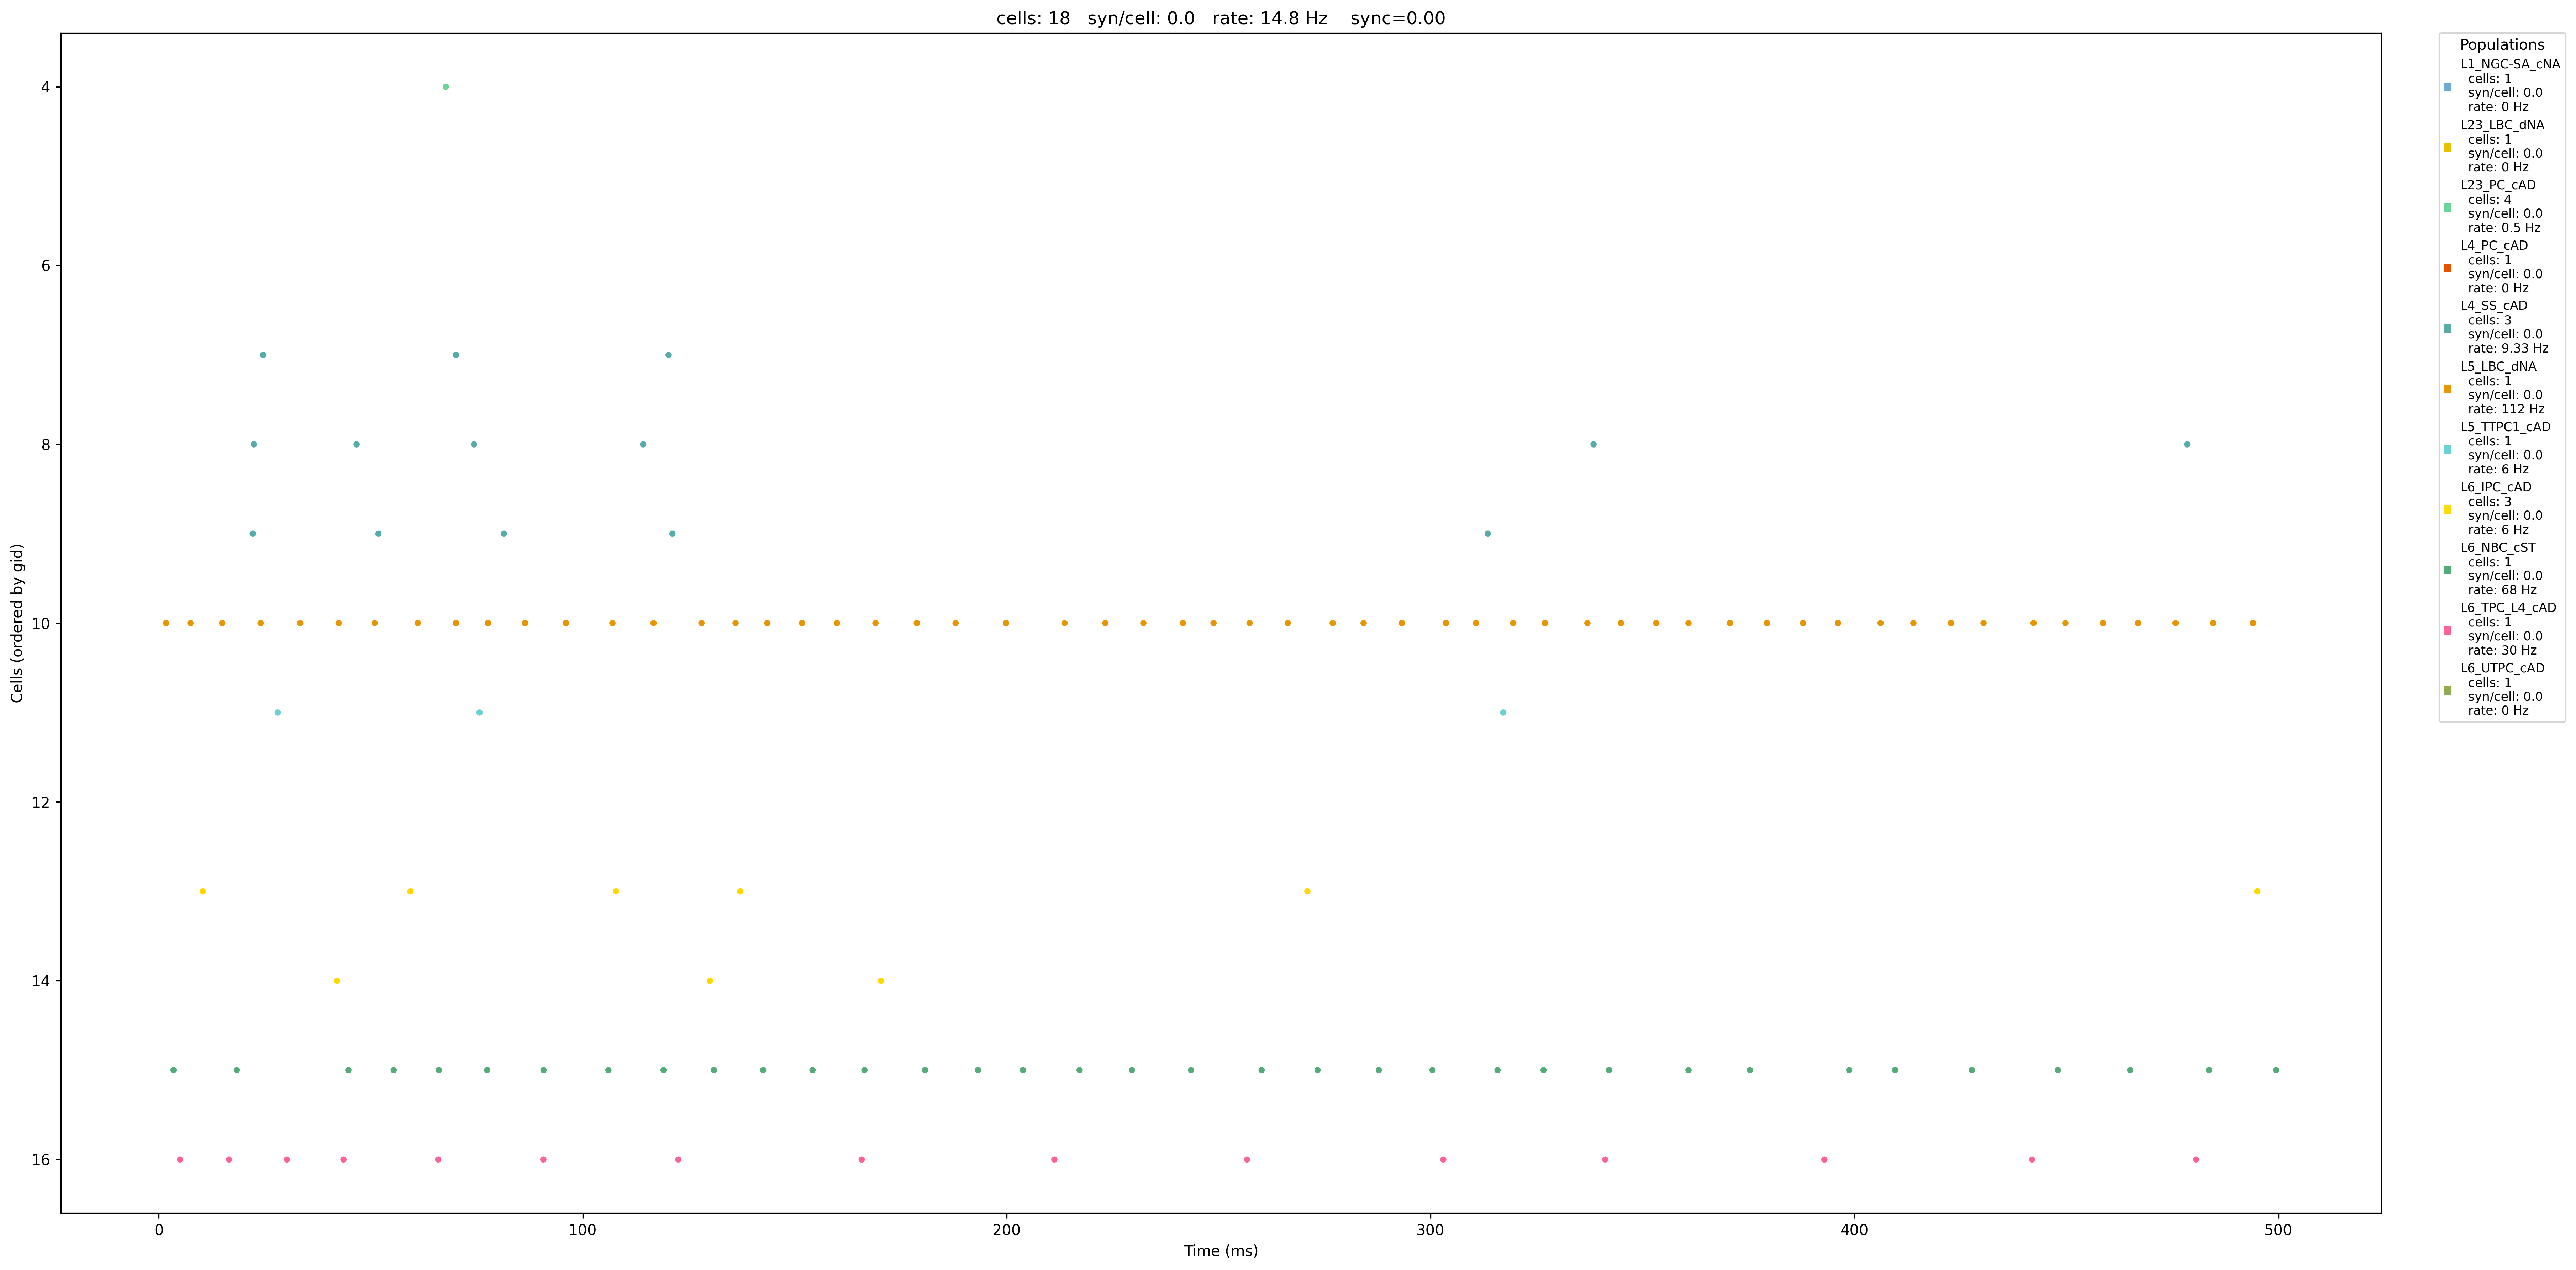

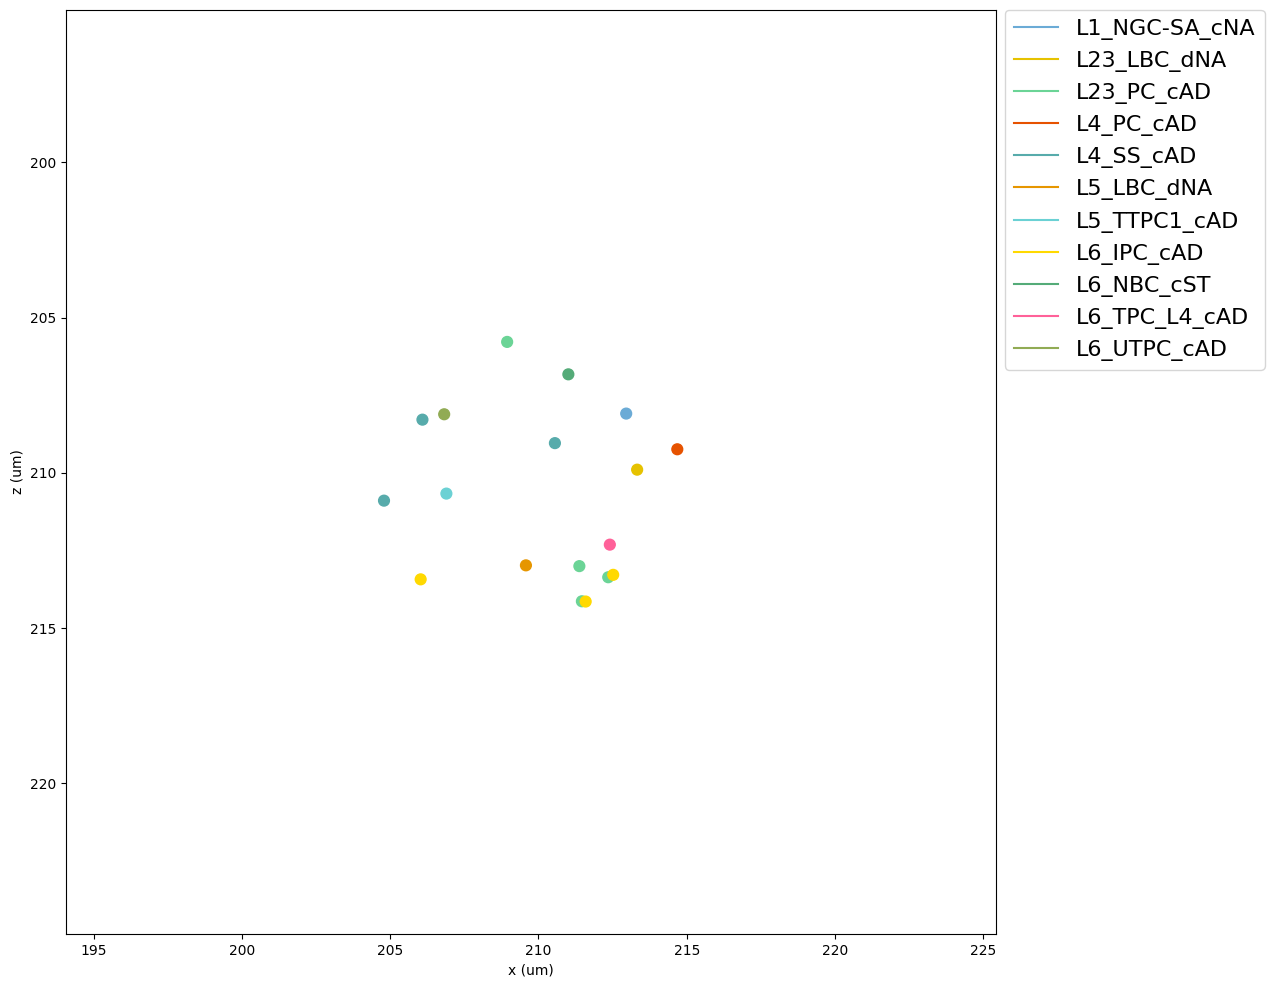

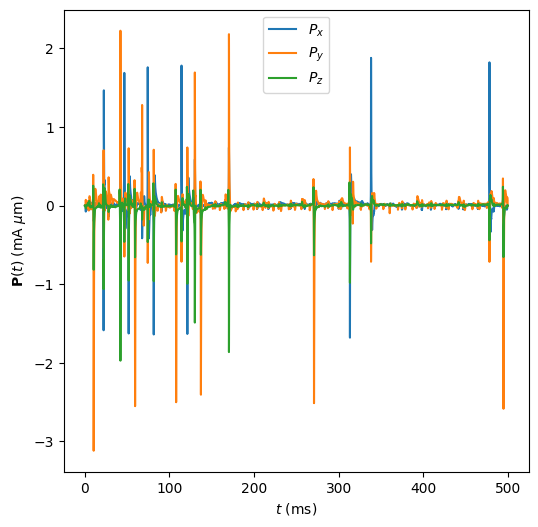

  Done; plotting time = 2.35 s

Total time = 208.23 s


In [13]:
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc


Plotting recorded cell traces ... trace


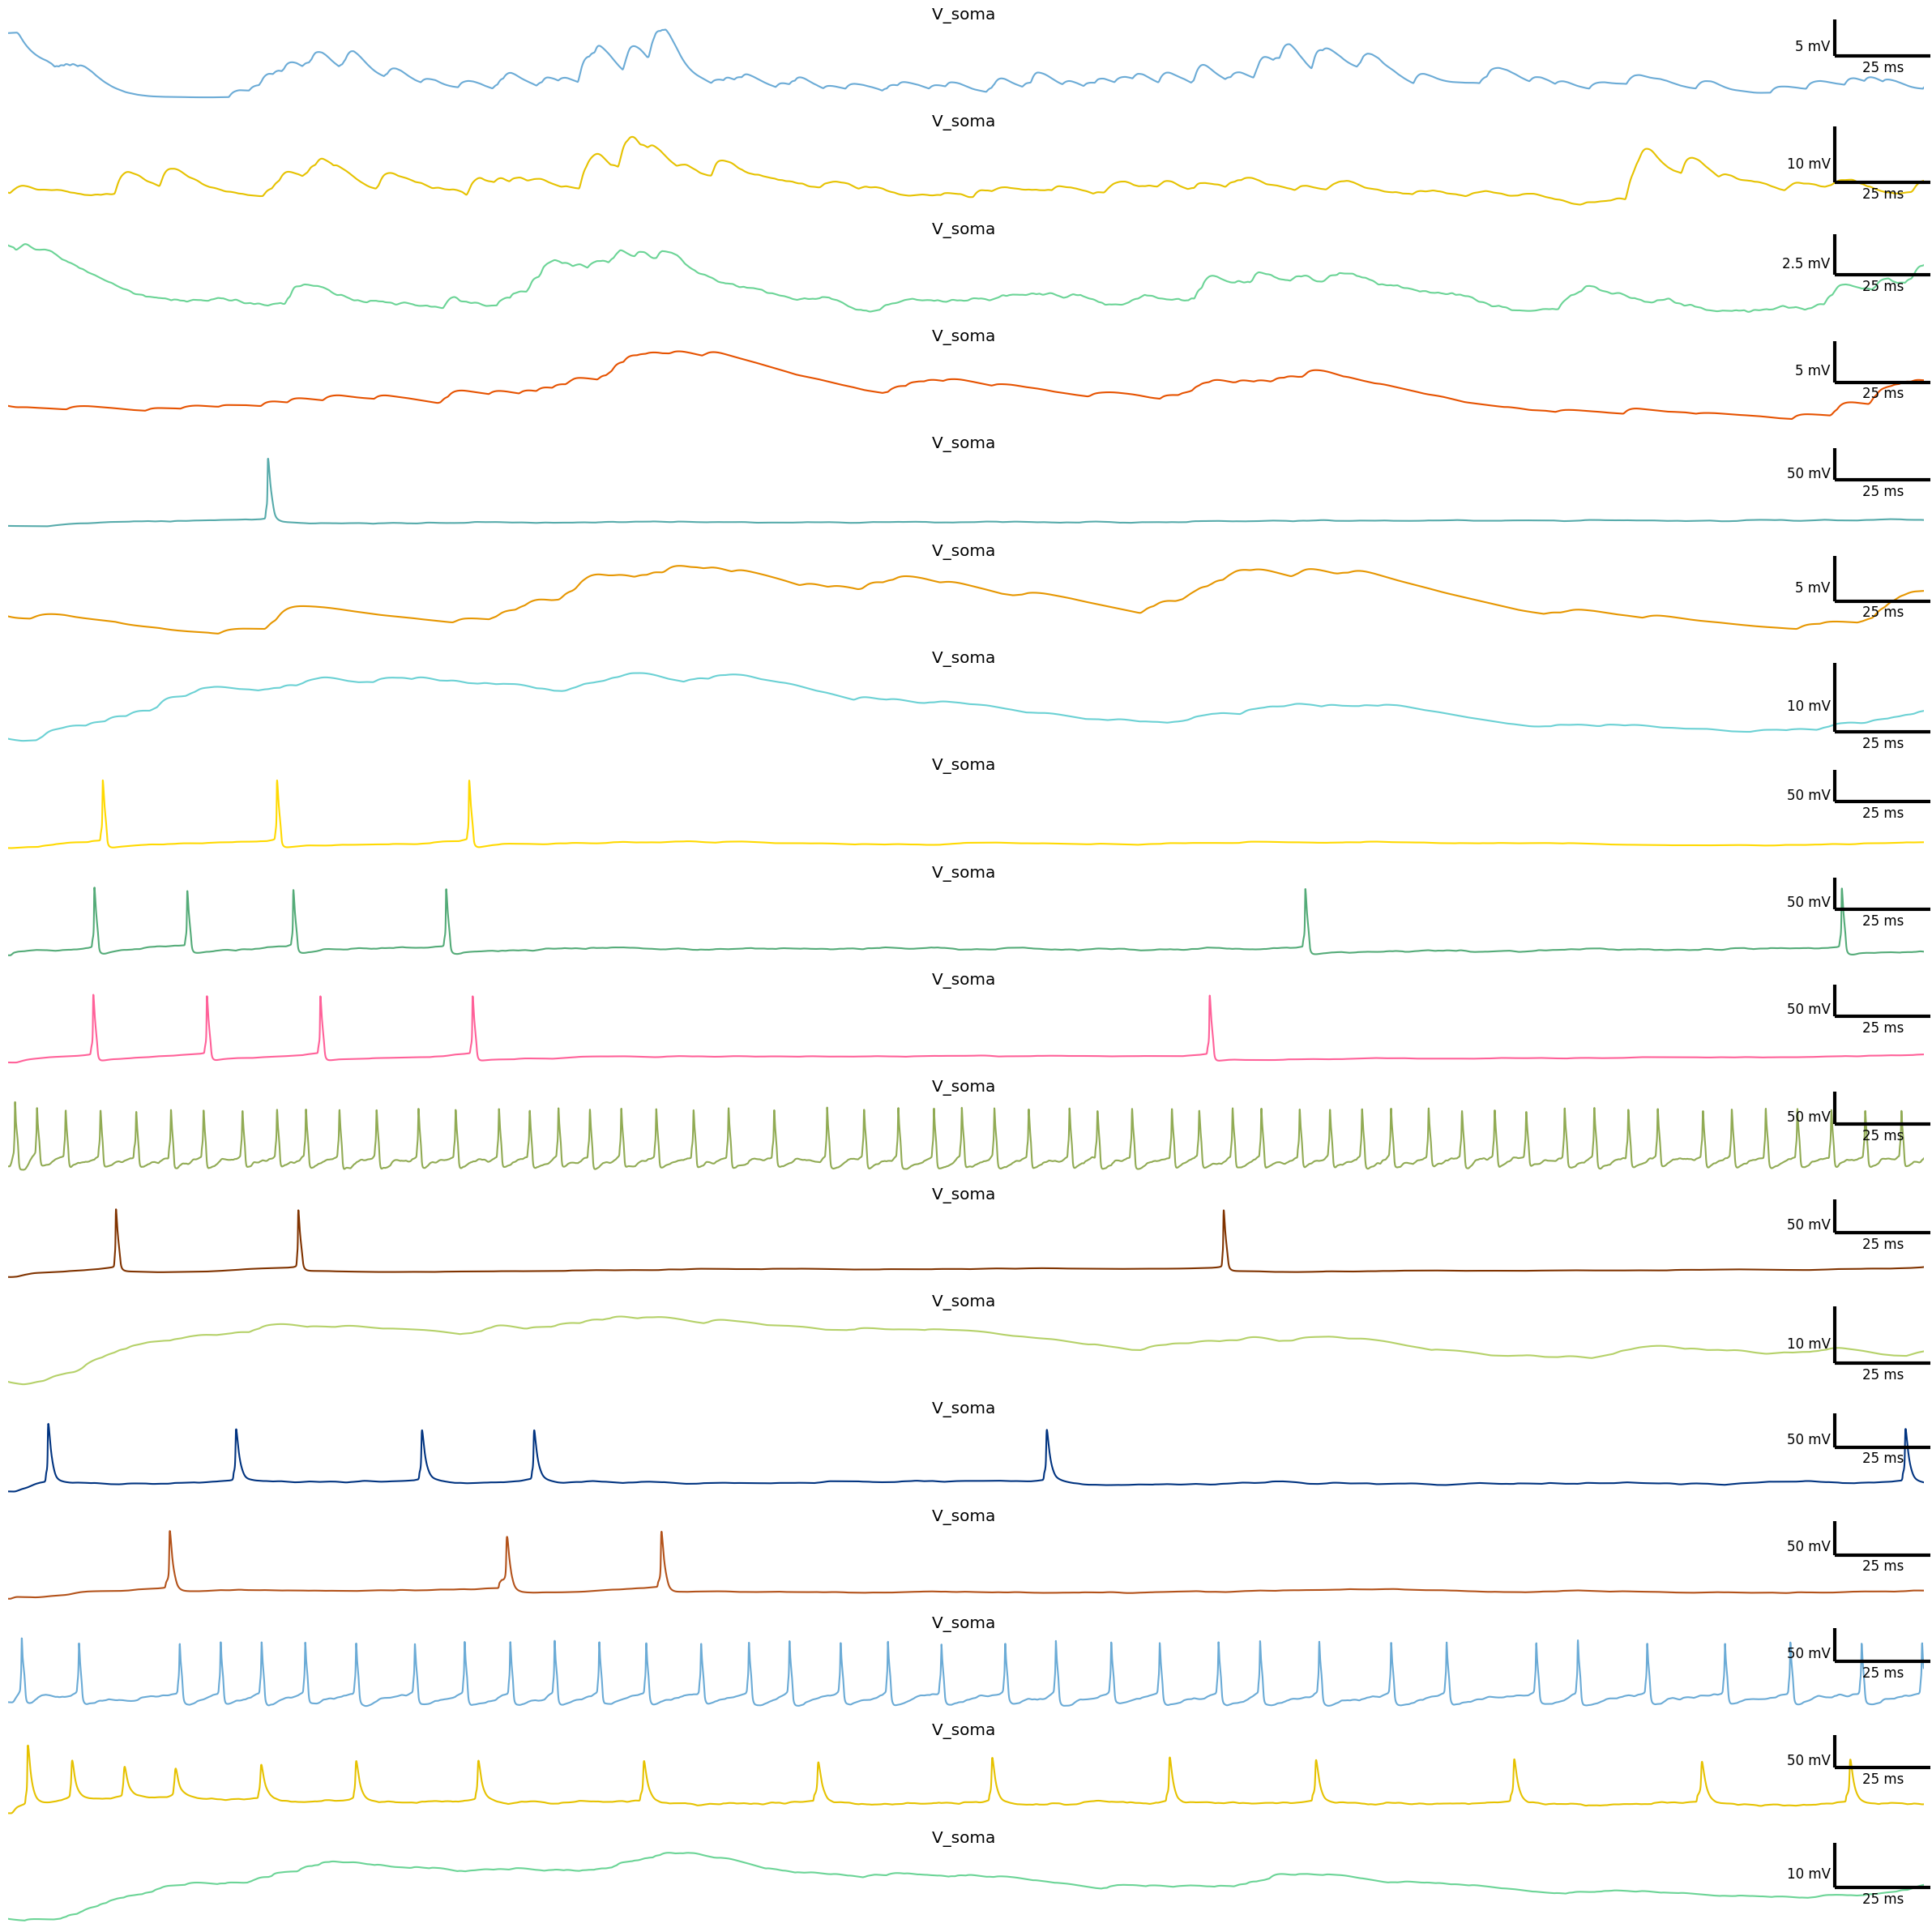

In [14]:
sim.analysis.plotTraces(timeRange=[0,500], oneFigPer='trace', axis=False, overlay= False, figSize=(24, 24));

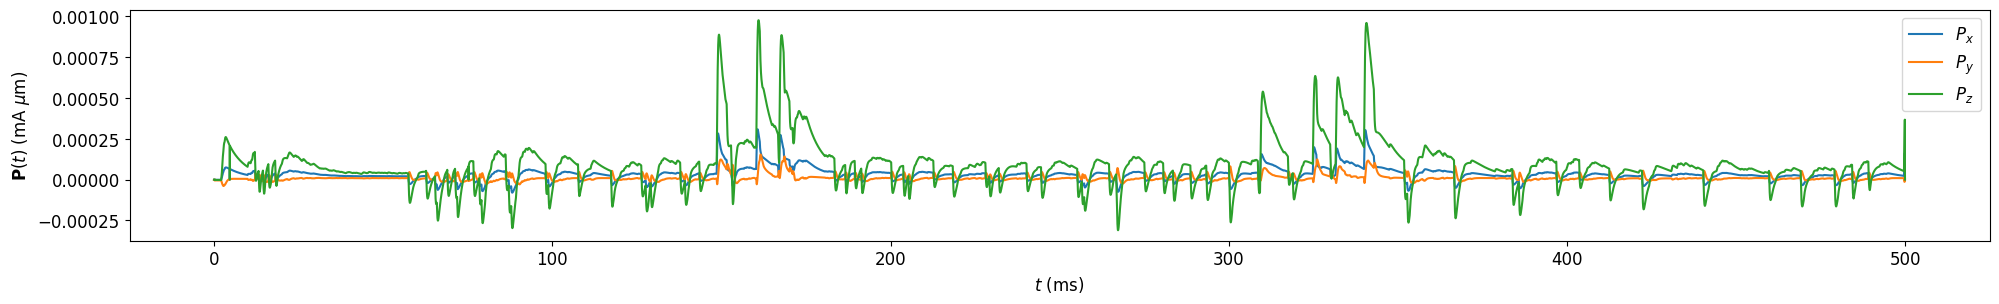

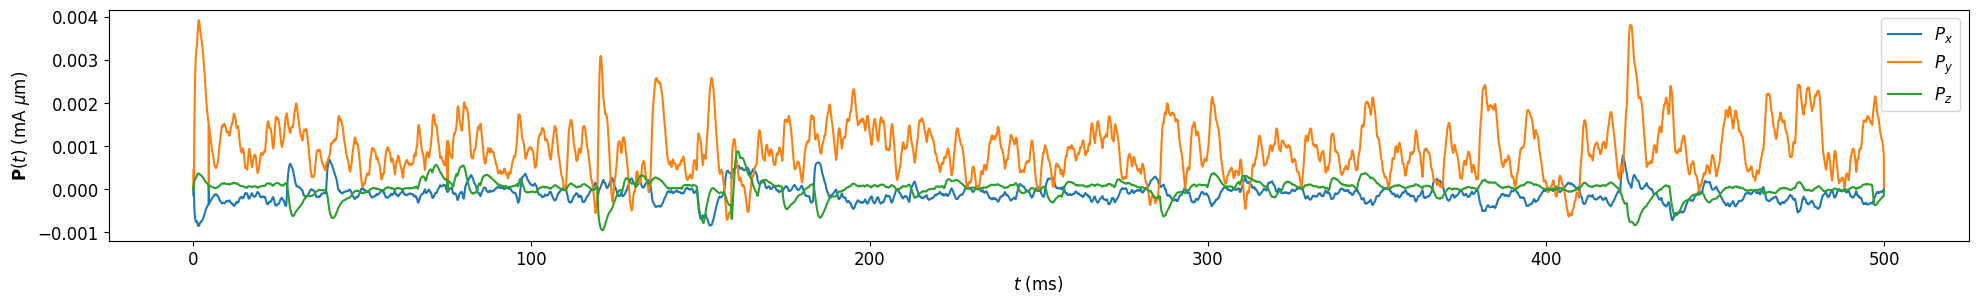

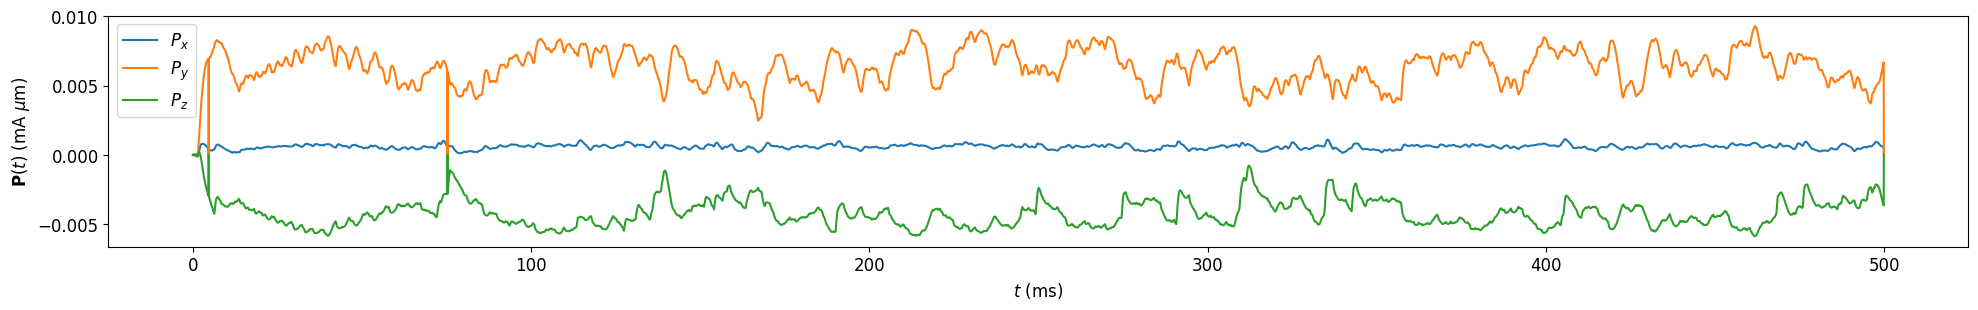

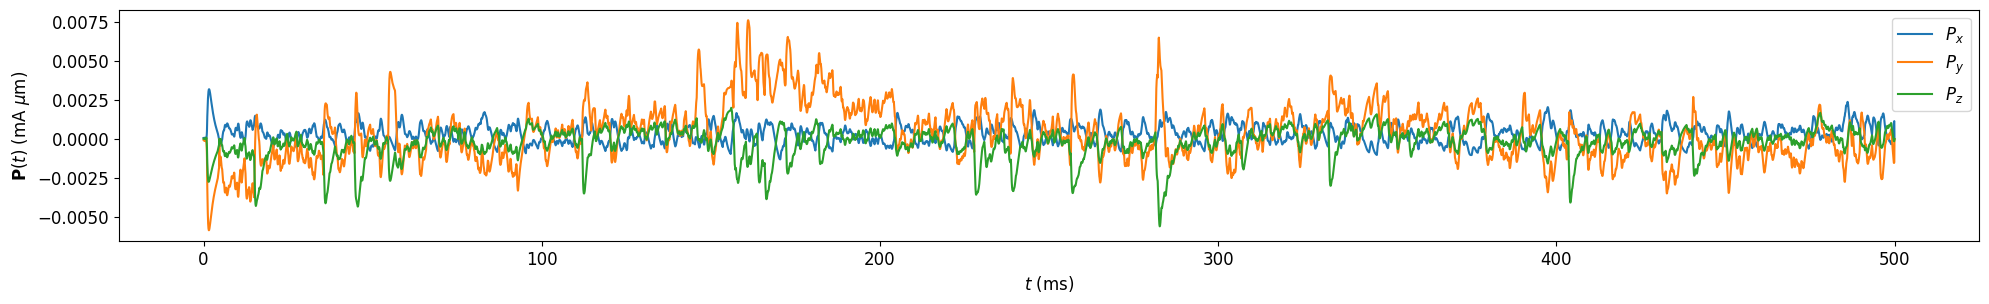

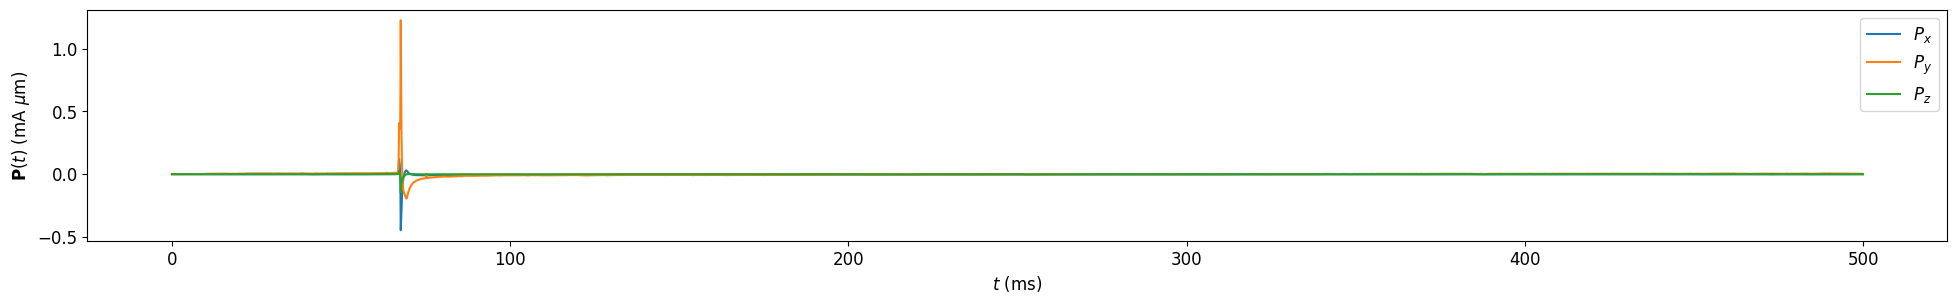

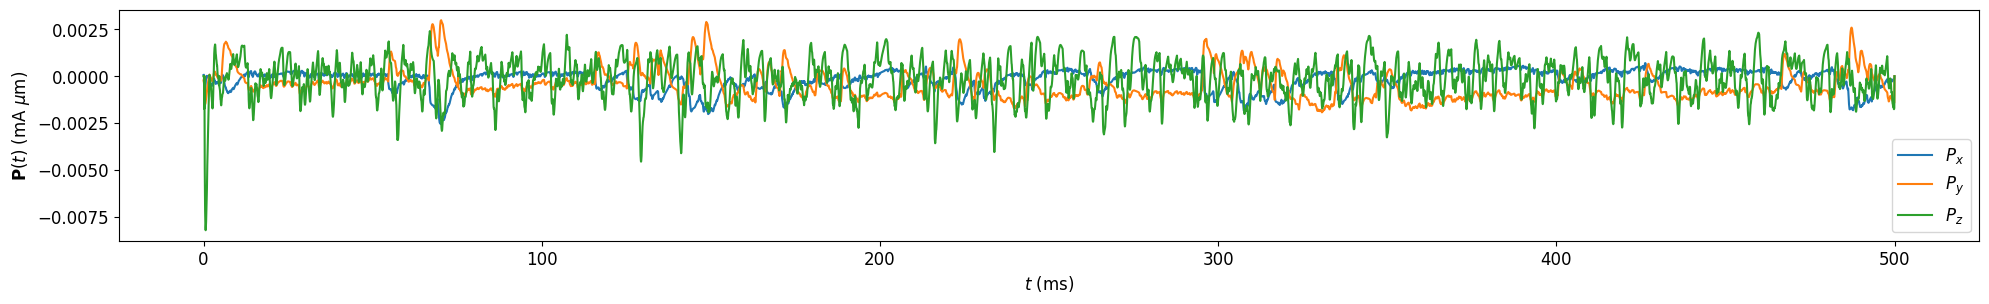

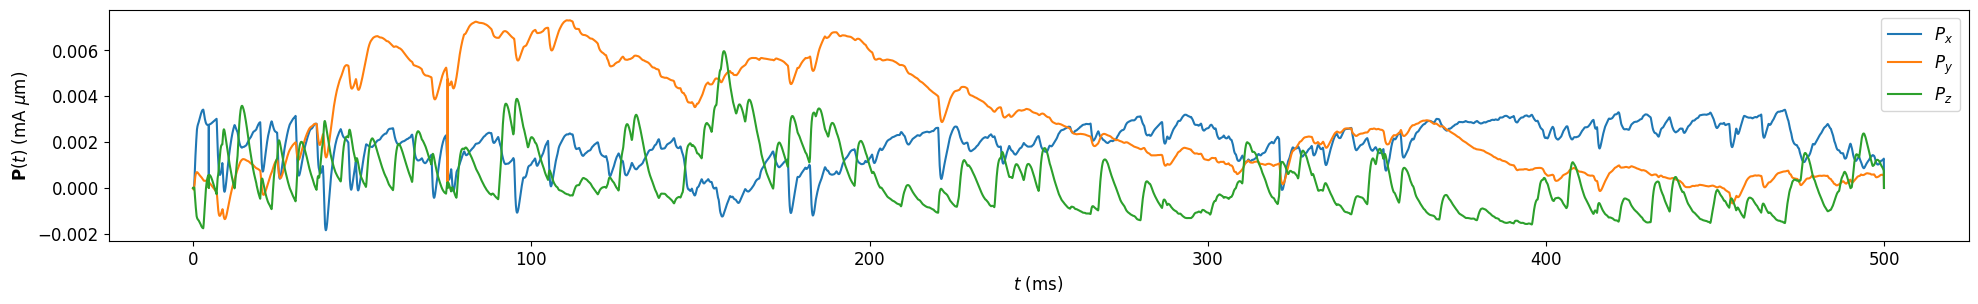

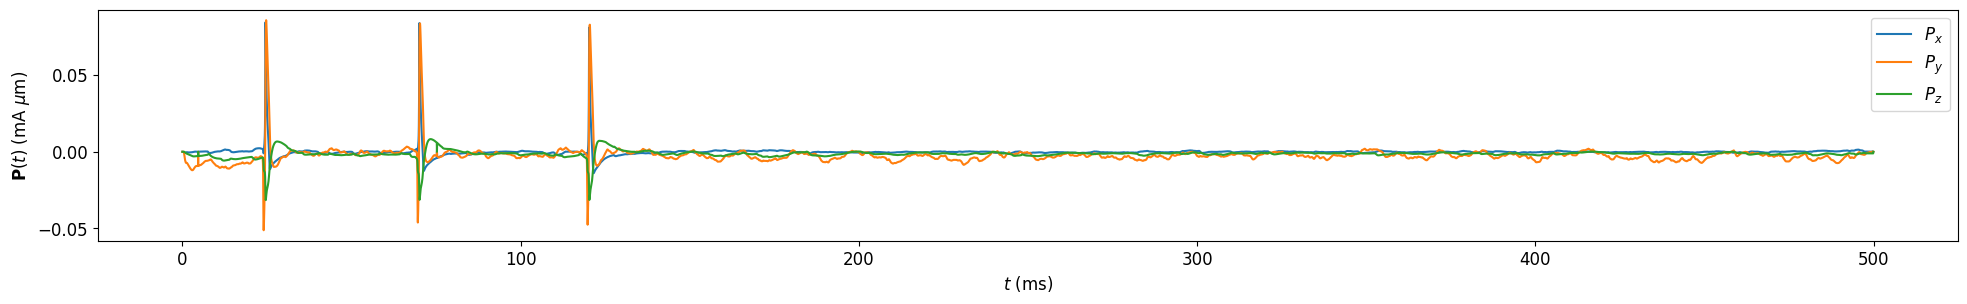

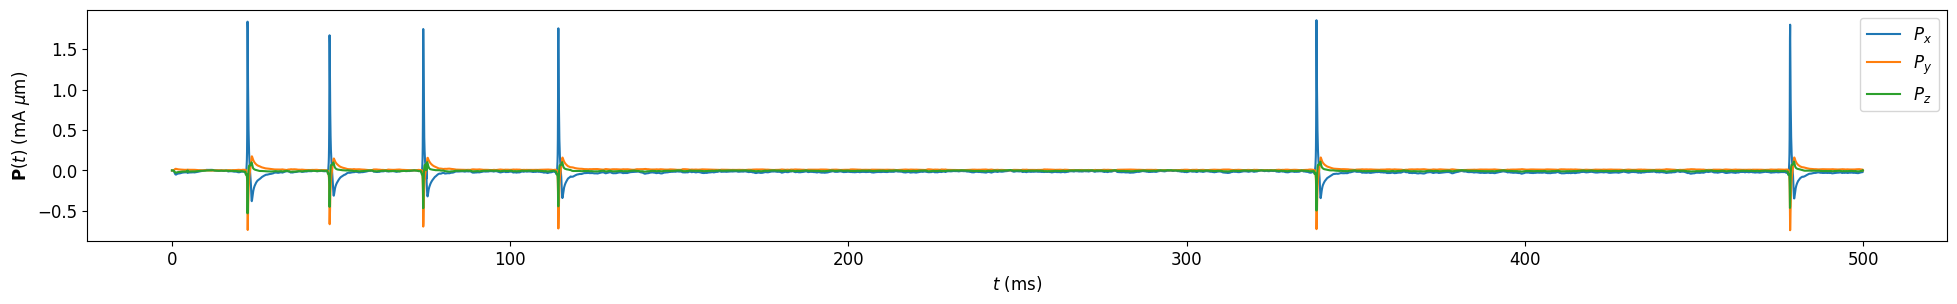

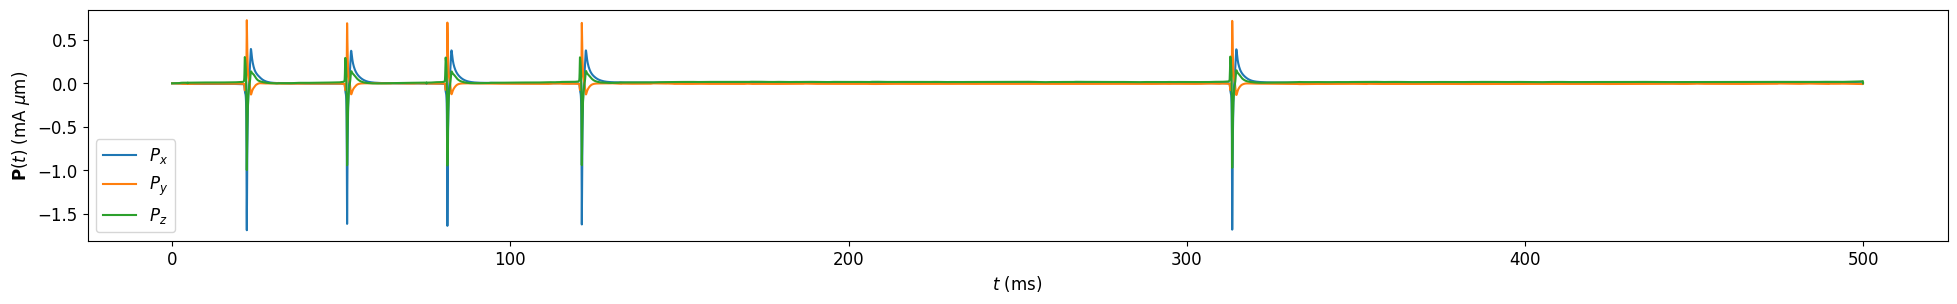

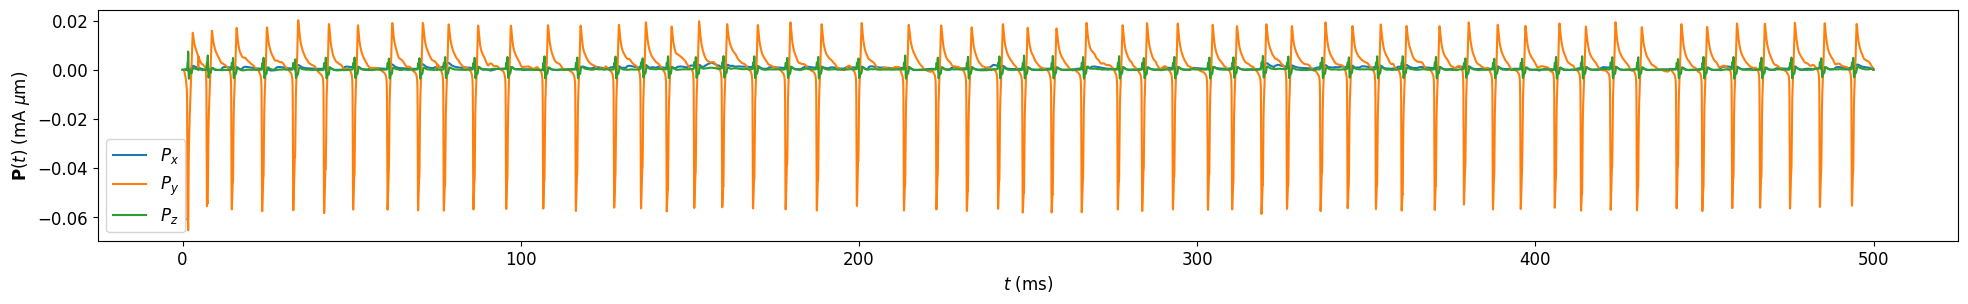

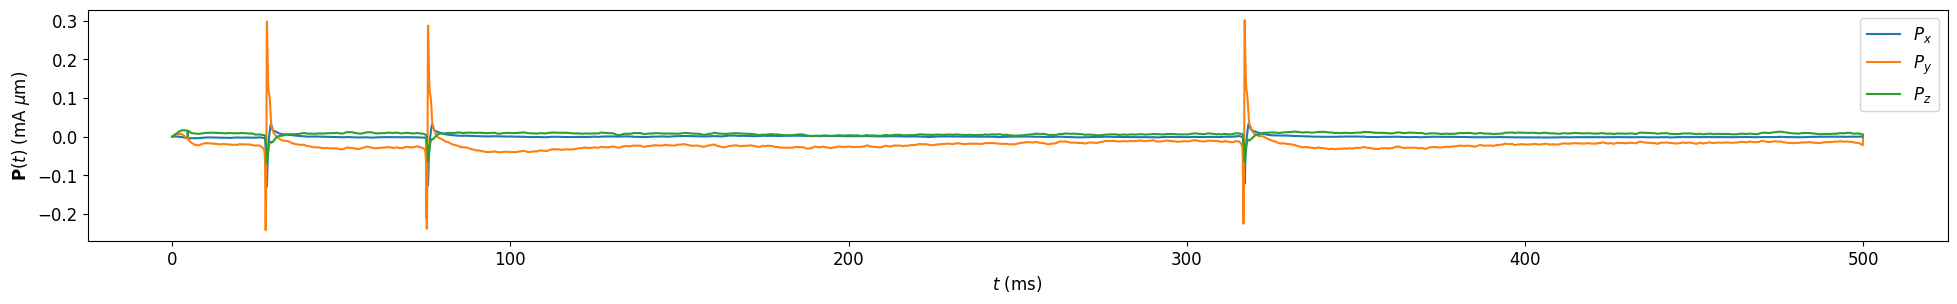

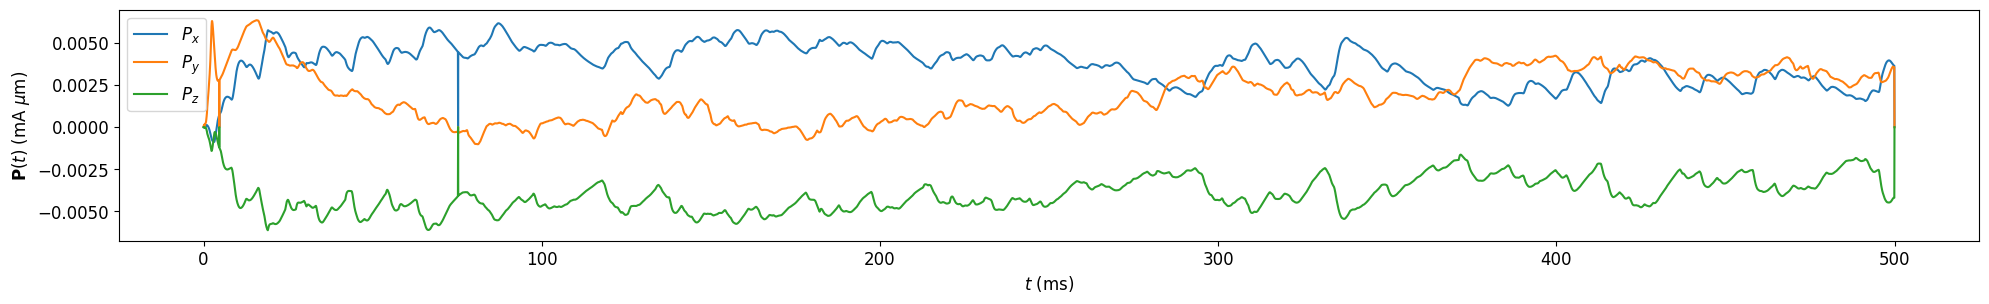

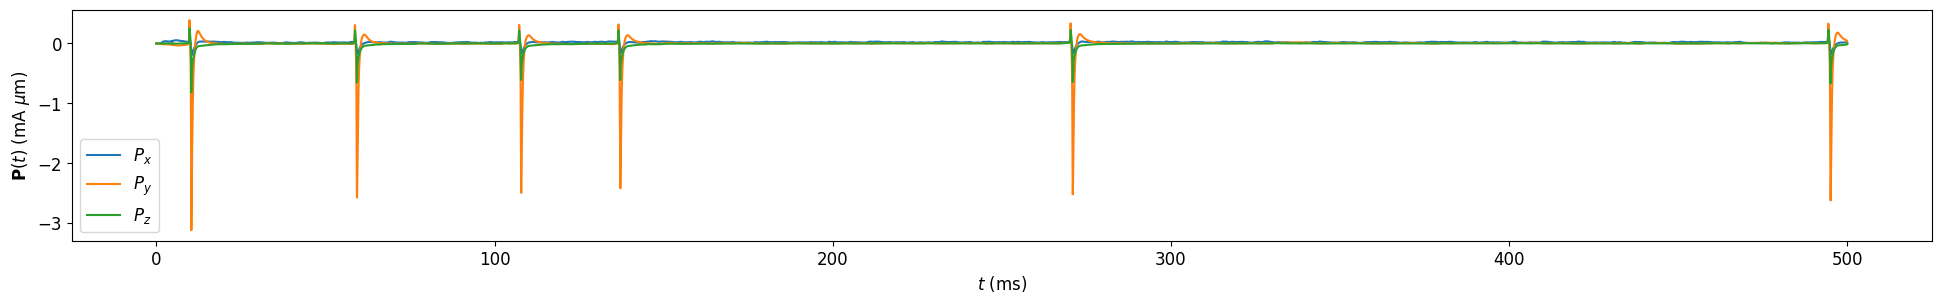

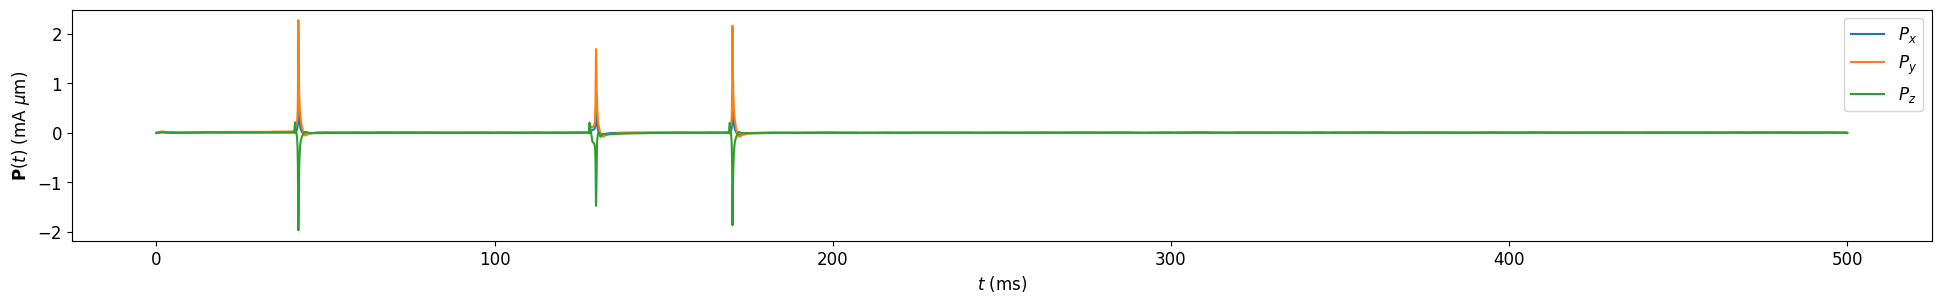

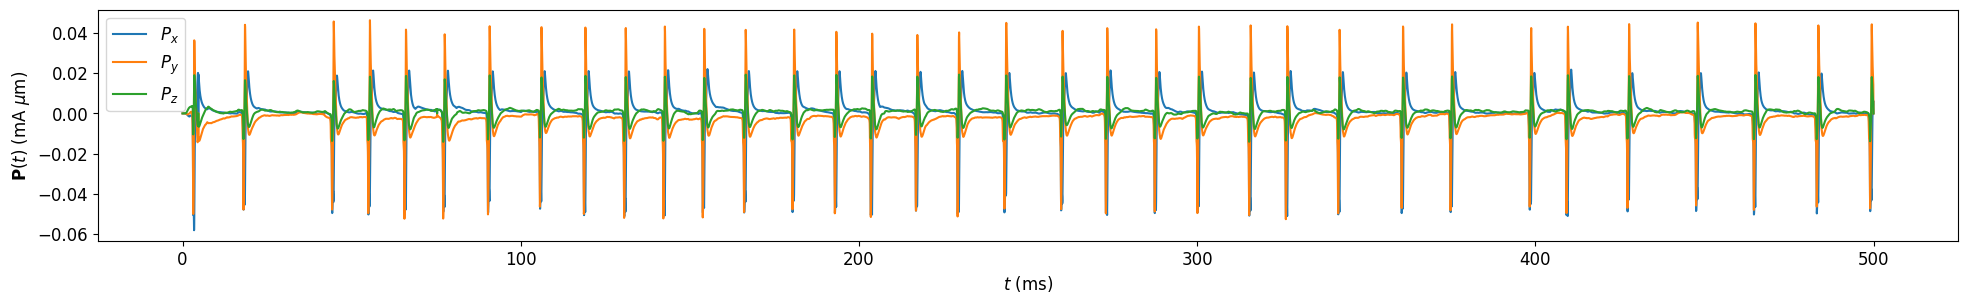

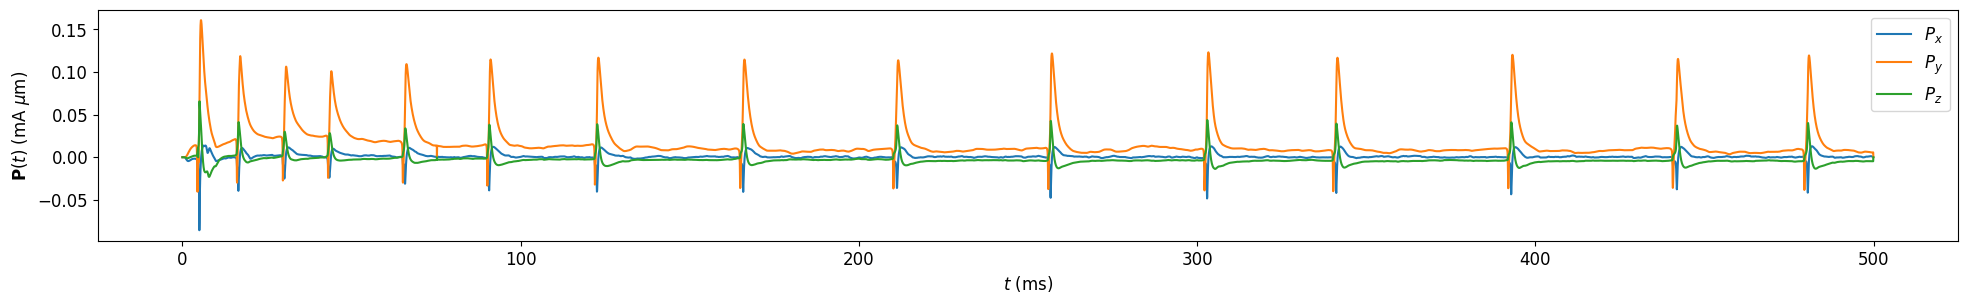

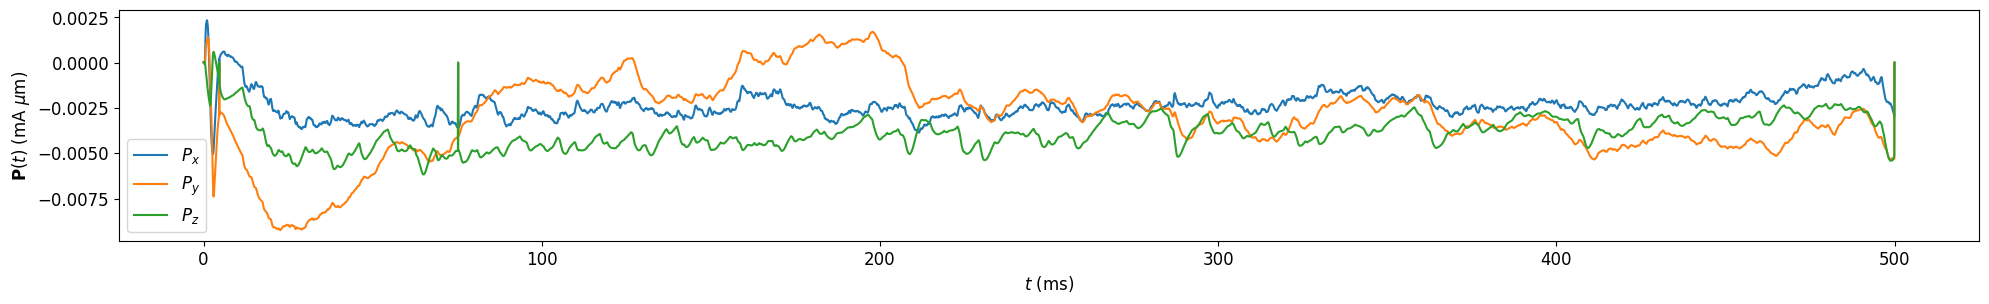

In [15]:
for ii in range(1,38444):
    try:
        sim.analysis.plotDipole(showCell=ii, timeRange=[0,500], dpi=300, figSize=(24, 3))
    except:
        a = 0

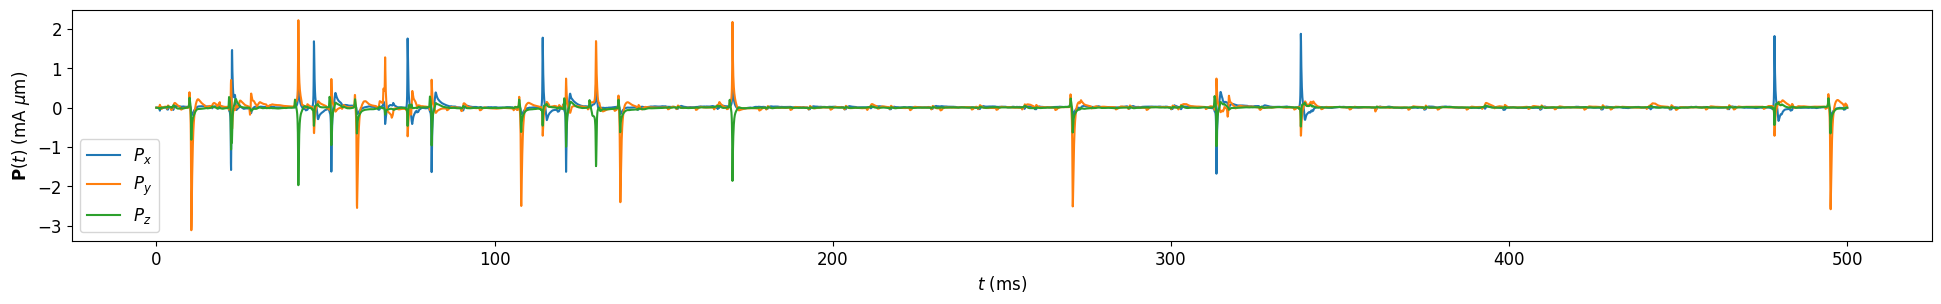

In [16]:
sim.analysis.plotDipole(timeRange=[0,500], dpi=300, figSize=(24, 3))

Plotting 3D cell shape ...


(<Figure size 640x480 with 2 Axes>, {})

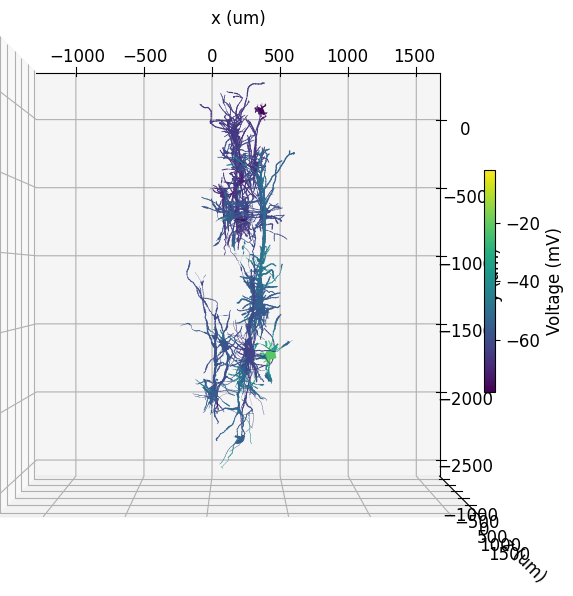

In [17]:
sim.analysis.plotShape(includePre=cfg.S1cells,includePost=cfg.S1cells,showFig=True,cvar='voltage',axisLabels=True)

Plotting 3D cell shape ...


(<Figure size 640x480 with 2 Axes>, {})

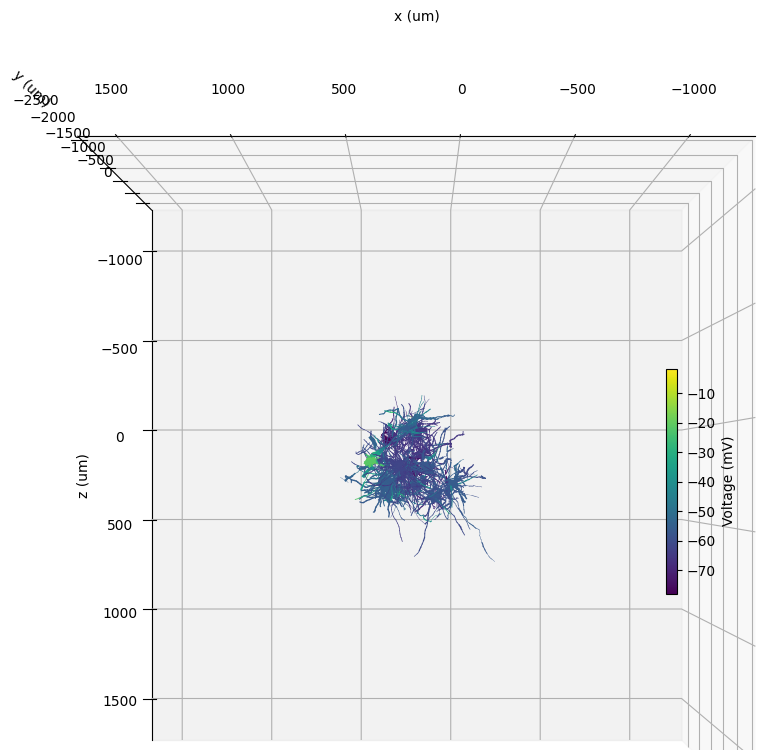

In [18]:
sim.analysis.plotShape(includePre=cfg.S1cells,includePost=cfg.S1cells,showFig=True,cvar='voltage',dist=0.45,elev=180,azim=-270,axisLabels=True)